## Day 4 — Grad-CAM Failure Analysis (Rice Grain Journal Study)

Baseline model: ResNet50 (ImageNet), frozen backbone  
Saved model: experiments/exp001_baseline_resnet50/best_model.keras  
Critical note: preprocessing must match Day 3 training (ImageNet mean/std normalization).


In [27]:
import os
os.chdir("/home/arijit/Documents/rice_project")
print("CWD fixed:", os.getcwd())

import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from pathlib import Path
import matplotlib.pyplot as plt

SEED = 20260115
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

MODEL_PATH = Path("experiments/exp001_baseline_resnet50/best_model.keras")
print("TF version:", tf.__version__)
print("GPU devices:", tf.config.list_physical_devices("GPU"))
print("Model path exists:", MODEL_PATH.exists(), MODEL_PATH)

model = keras.models.load_model(MODEL_PATH)
print("✅ Model loaded")
model.summary(line_length=120)

CWD fixed: /home/arijit/Documents/rice_project
TF version: 2.20.0
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Model path exists: True experiments/exp001_baseline_resnet50/best_model.keras
✅ Model loaded


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                                        ┃ Output Shape                           ┃               Para
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━
│ input_layer_1 (InputLayer)                          │ (None, 224, 224, 3)                    │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ resnet50 (Functional)                               │ (None, 7, 7, 2048)                     │            23,587,
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ global_average_pooling2d (GlobalAveragePooling2D)   │ (None, 2048)                           │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ dropout (Dropout)                                   │ (None, 2048)                           │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ dense (Dense)                                       │ (None, 38)                             │                77,
└─────────────────────────────────────────────────────┴────────────────────────────────────────┴───────────────────

 Total params: 23,821,300 (90.87 MB)

 Trainable params: 77,862 (304.15 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 155,726 (608.31 KB)

### Load test.csv + build tf.data test dataset (no shuffle)

### `set paths + load CSV`

In [28]:
TEST_CSV = Path("data/splits/test.csv")
test_df = pd.read_csv(TEST_CSV)

print("Test CSV exists:", TEST_CSV.exists(), TEST_CSV)
print("Rows:", len(test_df))
print("Columns:", list(test_df.columns))
test_df.head(3)


Test CSV exists: True data/splits/test.csv
Rows: 3800
Columns: ['filepath', 'label']


,filepath,label
0,data/raw/BD85/bd85 (223).jpg,BD85
1,data/raw/BD56/bd56 (102).jpg,BD56
2,data/raw/Binadhan16/binadhan16 (379).jpg,Binadhan16


### define `label mapping` from CSV

```
This mapping was derived from test.csv and is kept only to demonstrate a label–index mismatch during Grad-CAM failure analysis setup.
All final analyses must use the training-time class mapping.

In [31]:
# Change these if your CSV uses different column names
PATH_COL = "filepath"
LABEL_COL = "label"

if PATH_COL not in test_df.columns or LABEL_COL not in test_df.columns:
    raise ValueError(f"Expected columns '{PATH_COL}' and '{LABEL_COL}'. Found: {list(test_df.columns)}")

# Deterministic class order (IMPORTANT)
class_names = sorted(test_df[LABEL_COL].unique().tolist())
label_to_id = {name: i for i, name in enumerate(class_names)}
id_to_label = {i: name for name, i in label_to_id.items()}

print("Num classes:", len(class_names))
print("First 10 classes:", class_names[:10])


Num classes: 38
First 10 classes: ['BD30', 'BD33', 'BD39', 'BD49', 'BD51', 'BD52', 'BD56', 'BD57', 'BD70', 'BD72']


### build the `tf.data test` pipeline

In [32]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

MEAN = tf.constant([0.485, 0.456, 0.406], dtype=tf.float32)
STD  = tf.constant([0.229, 0.224, 0.225], dtype=tf.float32)

def decode_and_preprocess(path, label_id):
    img_bytes = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img_bytes, channels=3)
    img = tf.image.resize(img, IMG_SIZE, method="bilinear")
    img = tf.cast(img, tf.float32) / 255.0
    img = (img - MEAN) / STD
    return img, label_id

paths = test_df[PATH_COL].astype(str).values
labels = test_df[LABEL_COL].map(label_to_id).astype(int).values

test_ds = tf.data.Dataset.from_tensor_slices((paths, labels))
test_ds = test_ds.map(lambda p, y: decode_and_preprocess(p, y), num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

x_batch, y_batch = next(iter(test_ds))
print("x batch:", x_batch.shape, x_batch.dtype)
print("y batch:", y_batch.shape, y_batch.dtype)


x batch: (32, 224, 224, 3) <dtype: 'float32'>
y batch: (32,) <dtype: 'int64'>


In [33]:

missing = [p for p in paths[:200] if not Path(p).exists()]  # sample check first 200
print("Missing in first 200:", len(missing))
if missing:
    print("Example missing path:", missing[0])

Missing in first 200: 0


### Predict on test + build test_predictions.csv

In [35]:
# Predict probabilities for all 3800 test samples
probs = model.predict(test_ds, verbose=1)
y_pred = probs.argmax(axis=1)
y_true = labels  # already aligned with paths order

pred_df = test_df.copy()
pred_df["y_true"] = y_true
pred_df["y_pred"] = y_pred
pred_df["true_name"] = pred_df["y_true"].map(id_to_label)
pred_df["pred_name"] = pred_df["y_pred"].map(id_to_label)
pred_df["p_pred"] = probs.max(axis=1)
pred_df["p_true"] = probs[np.arange(len(probs)), y_true]
pred_df["is_correct"] = (pred_df["y_true"] == pred_df["y_pred"])

# Overall metrics (quick)
print("✅ Test accuracy:", pred_df["is_correct"].mean())

# Save for journal/reproducibility
OUT_DIR = Path("outputs/xai/gradcam")
OUT_DIR.mkdir(parents=True, exist_ok=True)
pred_df.to_csv(OUT_DIR / "test_predictions.csv", index=False)
print("Saved:", OUT_DIR / "test_predictions.csv")

pred_df.head(5)


119/119 ━━━━━━━━━━━━━━━━━━━━ 11s 93ms/step
✅ Test accuracy: 0.47947368421052633
Saved: outputs/xai/gradcam/test_predictions.csv


,filepath,label,y_true,y_pred,true_name,pred_name,p_pred,p_true,is_correct
0,data/raw/BD85/bd85 (223).jpg,BD85,13,13,BD85,BD85,0.124465,0.124465,True
1,data/raw/BD56/bd56 (102).jpg,BD56,6,13,BD56,BD85,0.139319,0.026168,False
2,data/raw/Binadhan16/binadhan16 (379).jpg,Binadhan16,27,35,Binadhan16,Binadhan26,0.283462,0.121130,False
3,data/raw/BD33/bd33 (42).jpg,BD33,1,11,BD33,BD76,0.345404,0.227433,False
4,data/raw/BD76/bd76 (164).jpg,BD76,11,5,BD76,BD52,0.384833,0.062613,False


``` 
Visualization

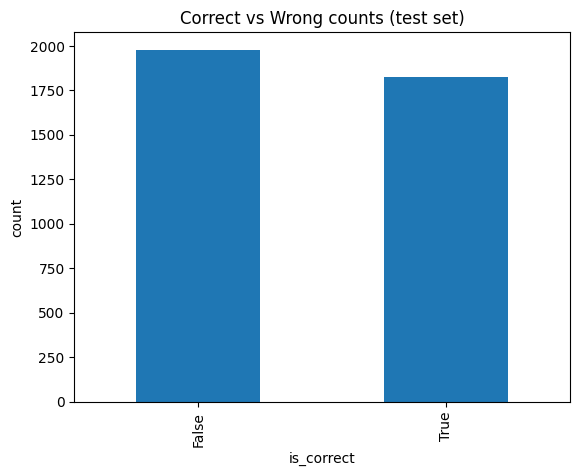

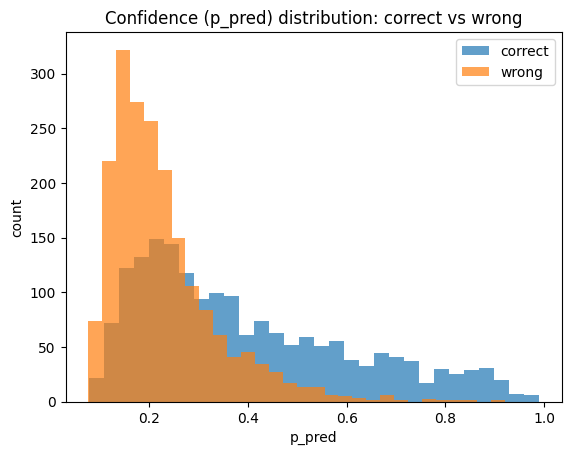

In [36]:
plt.figure()
pred_df["is_correct"].value_counts().plot(kind="bar")
plt.title("Correct vs Wrong counts (test set)")
plt.xlabel("is_correct")
plt.ylabel("count")
plt.show()

plt.figure()
plt.hist(pred_df.loc[pred_df["is_correct"], "p_pred"], bins=30, alpha=0.7, label="correct")
plt.hist(pred_df.loc[~pred_df["is_correct"], "p_pred"], bins=30, alpha=0.7, label="wrong")
plt.title("Confidence (p_pred) distribution: correct vs wrong")
plt.xlabel("p_pred")
plt.ylabel("count")
plt.legend()
plt.show()


## Confusion Matrix Heatmap

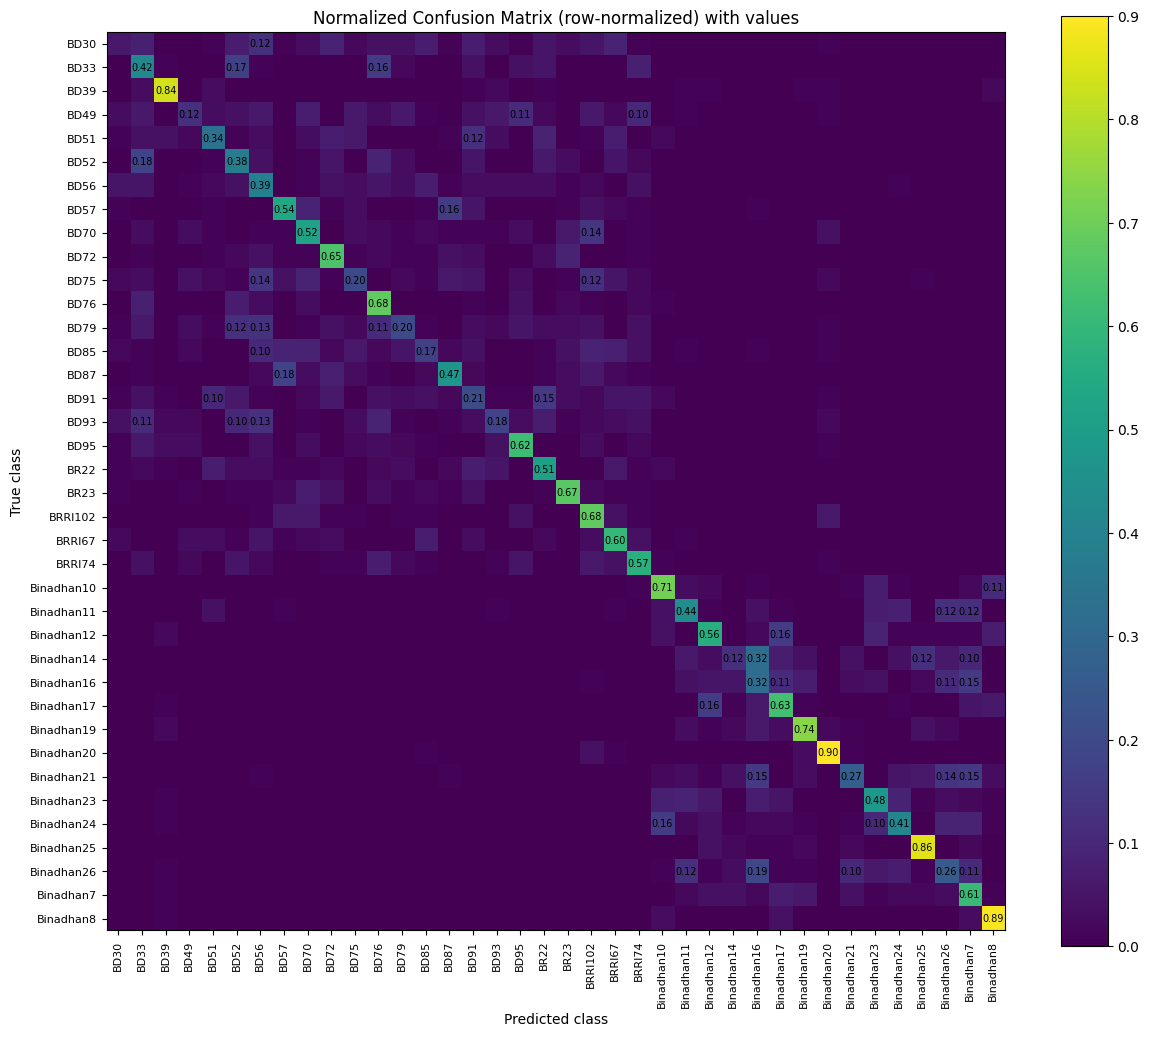

In [39]:
n = len(class_names)

# Confusion matrix counts
cm = np.zeros((n, n), dtype=np.int32)
for t, p in zip(pred_df["y_true"].values, pred_df["y_pred"].values):
    cm[t, p] += 1

# Row-normalized
cm_norm = cm / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(12, 10))
plt.imshow(cm_norm, interpolation="nearest")
plt.title("Normalized Confusion Matrix (row-normalized) with values")
plt.xlabel("Predicted class")
plt.ylabel("True class")
plt.colorbar()
plt.tight_layout()

# Axis tick labels (rice names)
plt.xticks(ticks=np.arange(n), labels=class_names, rotation=90, fontsize=8)
plt.yticks(ticks=np.arange(n), labels=class_names, fontsize=8)


# Overlay numbers (only show >= threshold to reduce clutter)
THRESH = 0.10  # change to 0.05 if you want more numbers
for i in range(n):
    for j in range(n):
        v = cm_norm[i, j]
        if v >= THRESH:
            plt.text(j, i, f"{v:.2f}", ha="center", va="center", fontsize=7)

plt.show()


## Extract and print the `top-10 confusion pairs`

In [40]:
n = len(class_names)

# counts
cm = np.zeros((n, n), dtype=np.int32)
for t, p in zip(pred_df["y_true"].values, pred_df["y_pred"].values):
    cm[t, p] += 1

# row-normalized
cm_norm = cm / cm.sum(axis=1, keepdims=True)

# get off-diagonal entries
pairs = []
for i in range(n):
    for j in range(n):
        if i != j and cm[i, j] > 0:
            pairs.append((class_names[i], class_names[j], cm[i, j], cm_norm[i, j]))

top = sorted(pairs, key=lambda x: x[3], reverse=True)[:10]

top_df = pd.DataFrame(top, columns=["true_class", "pred_class", "count", "row_norm_rate"])
top_df["row_norm_rate"] = top_df["row_norm_rate"].map(lambda v: round(float(v), 3))

print("Top-10 confusion pairs (true -> pred), sorted by row-normalized rate:")
top_df

Top-10 confusion pairs (true -> pred), sorted by row-normalized rate:


,true_class,pred_class,count,row_norm_rate
0,Binadhan14,Binadhan16,32,0.32
1,Binadhan26,Binadhan16,19,0.19
2,BD52,BD33,18,0.18
3,BD87,BD57,18,0.18
4,BD33,BD52,17,0.17
5,BD33,BD76,16,0.16
6,BD57,BD87,16,0.16
7,Binadhan12,Binadhan17,16,0.16
8,Binadhan17,Binadhan12,16,0.16
9,Binadhan24,Binadhan10,16,0.16


## Create `selected_cases.csv` for Grad-CAM

In [41]:
OUT_DIR = Path("outputs/xai/gradcam")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# paste your top pairs here (true_class, pred_class)
top_pairs = [
    ("Binadhan14", "Binadhan16"),
    ("Binadhan26", "Binadhan16"),
    ("BD52", "BD33"),
    ("BD87", "BD57"),
    ("BD33", "BD52"),
    ("BD33", "BD76"),
    ("BD57", "BD87"),
    ("Binadhan12", "Binadhan17"),
    ("Binadhan17", "Binadhan12"),
    ("Binadhan24", "Binadhan10"),
]

N_WRONG = 8
N_RIGHT = 8

selected_rows = []

# 1) wrong samples for each confusion pair
for t, p in top_pairs:
    df_pair = pred_df[(pred_df["true_name"] == t) & (pred_df["pred_name"] == p)]
    df_pair = df_pair.sort_values("p_pred", ascending=False).head(N_WRONG)
    selected_rows.append(df_pair.assign(selection_type="wrong_pair"))

# 2) correct samples for each unique true class involved
true_classes = sorted(set([t for t, _ in top_pairs]))
for t in true_classes:
    df_ok = pred_df[(pred_df["true_name"] == t) & (pred_df["is_correct"] == True)]
    df_ok = df_ok.sort_values("p_pred", ascending=False).head(N_RIGHT)
    selected_rows.append(df_ok.assign(selection_type="correct_ref"))

selected_df = pd.concat(selected_rows, ignore_index=True)

# keep only essential columns
keep_cols = ["filepath", "true_name", "pred_name", "p_true", "p_pred", "is_correct", "selection_type"]
selected_df = selected_df[keep_cols]

out_path = OUT_DIR / "selected_cases.csv"
selected_df.to_csv(out_path, index=False)

print("Saved:", out_path)
print("Total selected:", len(selected_df))
print(selected_df["selection_type"].value_counts())
selected_df.head(10)


Saved: outputs/xai/gradcam/selected_cases.csv
Total selected: 152
selection_type
wrong_pair     80
correct_ref    72
Name: count, dtype: int64


,filepath,true_name,pred_name,p_true,p_pred,is_correct,selection_type
0,data/raw/Binadhan14/binadhan14 (258).jpg,Binadhan14,Binadhan16,0.222958,0.649291,False,wrong_pair
1,data/raw/Binadhan14/binadhan14 (156).jpg,Binadhan14,Binadhan16,0.256928,0.455619,False,wrong_pair
2,data/raw/Binadhan14/binadhan14 (142).jpg,Binadhan14,Binadhan16,0.191714,0.427201,False,wrong_pair
3,data/raw/Binadhan14/binadhan14 (187).jpg,Binadhan14,Binadhan16,0.240917,0.381399,False,wrong_pair
4,data/raw/Binadhan14/binadhan14 (201).jpg,Binadhan14,Binadhan16,0.184905,0.340888,False,wrong_pair
5,data/raw/Binadhan14/binadhan14 (198).jpg,Binadhan14,Binadhan16,0.291403,0.335416,False,wrong_pair
6,data/raw/Binadhan14/binadhan14 (42).jpg,Binadhan14,Binadhan16,0.207222,0.322962,False,wrong_pair
7,data/raw/Binadhan14/binadhan14 (136).jpg,Binadhan14,Binadhan16,0.227768,0.311220,False,wrong_pair
8,data/raw/Binadhan26/binadhan26 (172).jpg,Binadhan26,Binadhan16,0.062753,0.439117,False,wrong_pair
9,data/raw/Binadhan26/binadhan26 (43).jpg,Binadhan26,Binadhan16,0.129695,0.397940,False,wrong_pair


### `Visualize a grid` of selected images

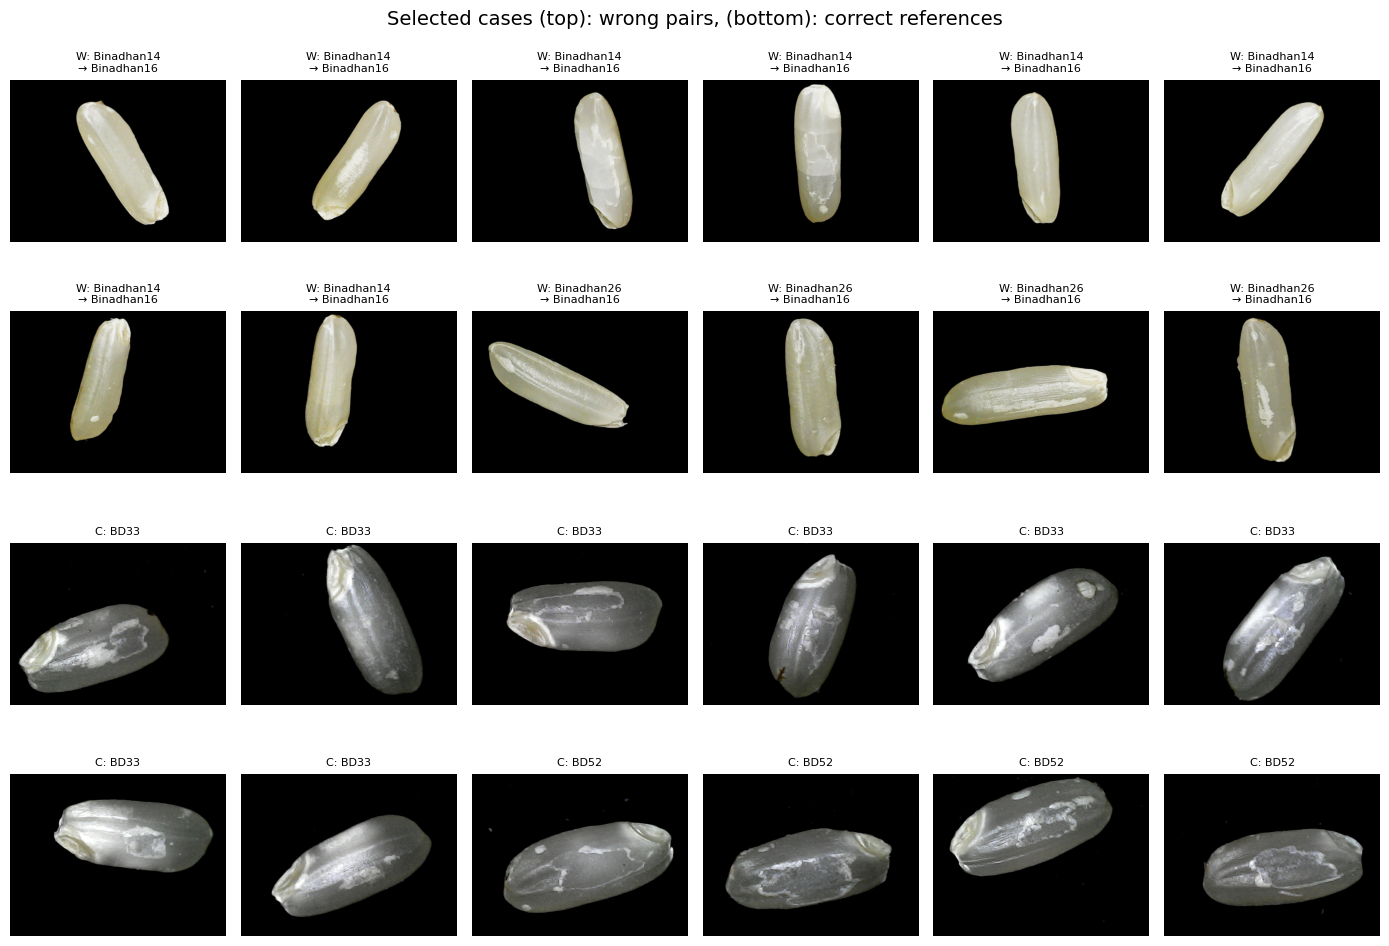

In [43]:
sel_path = Path("outputs/xai/gradcam/selected_cases.csv")
sel_df = pd.read_csv(sel_path)

# take 12 wrong + 12 correct
wrong = sel_df[sel_df["selection_type"]=="wrong_pair"].head(12)
right = sel_df[sel_df["selection_type"]=="correct_ref"].head(12)

show_df = pd.concat([wrong, right], ignore_index=True)

plt.figure(figsize=(14, 10))
for i, row in enumerate(show_df.itertuples(index=False), start=1):
    img_bytes = tf.io.read_file(row.filepath)
    img = tf.image.decode_jpeg(img_bytes, channels=3).numpy()

    ax = plt.subplot(4, 6, i)
    ax.imshow(img)
    ax.axis("off")

    # short titles
    if row.selection_type == "wrong_pair":
        title = f"W: {row.true_name}\n→ {row.pred_name}"
    else:
        title = f"C: {row.true_name}"
    ax.set_title(title, fontsize=8)

plt.suptitle("Selected cases (top): wrong pairs, (bottom): correct references", fontsize=14)
plt.tight_layout()
plt.show()

## Implement `Grad-CAM function`

### grad cam helper functions

In [70]:
def load_image_for_model(path):
    # uses SAME preprocessing as Day 3 (mean/std) already defined earlier
    img_bytes = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img_bytes, channels=3)
    img = tf.image.resize(img, IMG_SIZE, method="bilinear")
    img = tf.cast(img, tf.float32) / 255.0
    img = (img - MEAN) / STD
    return img  # (224,224,3)

def overlay_heatmap_on_rgb(img_rgb_uint8, heatmap_01, alpha=0.45):
    """
    img_rgb_uint8: HxWx3 uint8 (original image)
    heatmap_01: 224x224 float in [0,1] (from Grad-CAM)
    returns: HxWx3 uint8 overlay
    """
    H, W = img_rgb_uint8.shape[:2]

    # resize heatmap to match original image size
    hm = tf.convert_to_tensor(heatmap_01[..., np.newaxis], dtype=tf.float32)   # 224x224x1
    hm = tf.image.resize(hm, (H, W), method="bilinear")
    hm = tf.squeeze(hm, axis=-1).numpy()  # HxW

    hm_uint8 = np.uint8(255 * hm)
    hm_rgb = np.stack([hm_uint8]*3, axis=-1)

    out = (1 - alpha) * img_rgb_uint8 + alpha * hm_rgb
    return np.uint8(np.clip(out, 0, 255))

print("✅ Grad-CAM helpers ready")


✅ Grad-CAM helpers ready


In [71]:
# --- 1) Grab layers from your trained model (same instances) ---
backbone = model.get_layer("resnet50")
gap = model.get_layer("global_average_pooling2d")
drop = model.get_layer("dropout")
clf = model.get_layer("dense")

# --- 2) Choose a target feature layer INSIDE the backbone graph ---
backbone_layer_names = [l.name for l in backbone.layers]
if "conv5_block3_out" in backbone_layer_names:
    TARGET_LAYER_NAME = "conv5_block3_out"          # commonly best for ResNet50
else:
    # fallback: last Conv2D layer
    conv2d_names = [l.name for l in backbone.layers if isinstance(l, keras.layers.Conv2D)]
    TARGET_LAYER_NAME = conv2d_names[-1]

print("✅ Grad-CAM target layer:", TARGET_LAYER_NAME)

# Model that returns: (target_conv_feature_map, backbone_output)
backbone_cam_model = keras.Model(
    inputs=backbone.input,
    outputs=[backbone.get_layer(TARGET_LAYER_NAME).output, backbone.output]
)

def make_gradcam_heatmap(img_tensor, class_index):
    """
    img_tensor: (224,224,3) preprocessed with mean/std
    class_index: int
    returns: heatmap (224,224) in [0,1]
    """
    img_batch = tf.expand_dims(img_tensor, axis=0)

    with tf.GradientTape() as tape:
        # Forward through backbone
        conv_out, backbone_out = backbone_cam_model(img_batch, training=False)

        # Forward through head (same layers as your trained model)
        x = gap(backbone_out)
        x = drop(x, training=False)
        preds = clf(x)  # (1, 38)

        score = preds[0, class_index]

    grads = tape.gradient(score, conv_out)
    if grads is None:
        raise RuntimeError("Gradients are None even in manual forward. This would be very unusual.")

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))  # (C,)
    conv_out = conv_out[0]                                # (H,W,C)

    heatmap = tf.reduce_sum(conv_out * pooled_grads, axis=-1)
    heatmap = tf.nn.relu(heatmap)
    heatmap = heatmap / (tf.reduce_max(heatmap) + 1e-8)

    heatmap = tf.image.resize(heatmap[..., tf.newaxis], IMG_SIZE)
    heatmap = tf.squeeze(heatmap, axis=-1)
    return heatmap.numpy()

# Quick sanity check: grads should not be None
dummy = tf.zeros((224,224,3), dtype=tf.float32)
hm = make_gradcam_heatmap(dummy, 0)
print("✅ Grad-CAM sanity check OK. Heatmap range:", float(hm.min()), float(hm.max()))


✅ Grad-CAM target layer: conv5_block3_out
✅ Grad-CAM sanity check OK. Heatmap range: 0.0 0.0


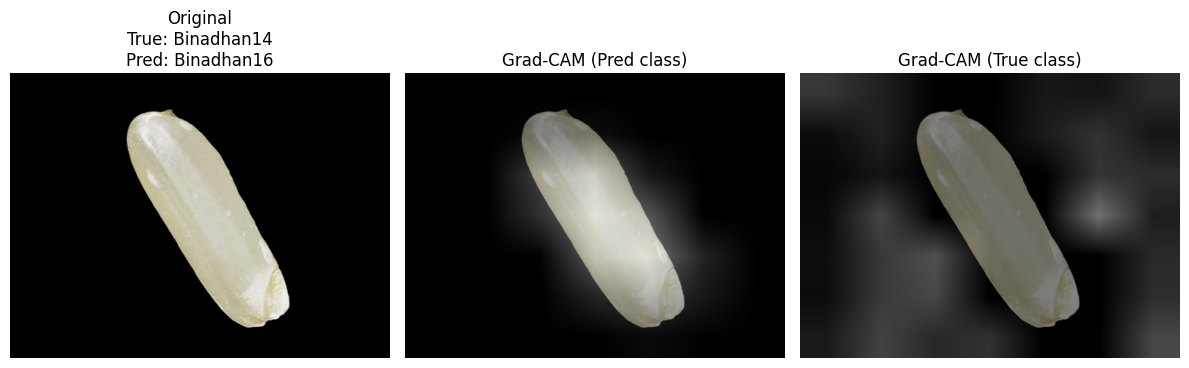

filepath: data/raw/Binadhan14/binadhan14 (258).jpg
p_true: 0.22295824 p_pred: 0.6492909


In [72]:
sel_df = pd.read_csv("outputs/xai/gradcam/selected_cases.csv")
row = sel_df[sel_df["selection_type"]=="wrong_pair"].iloc[0]

img = load_image_for_model(row.filepath)

true_idx = label_to_id[row.true_name]
pred_idx = label_to_id[row.pred_name]

hm_pred = make_gradcam_heatmap(img, pred_idx)
hm_true = make_gradcam_heatmap(img, true_idx)

img_disp = tf.image.decode_jpeg(tf.io.read_file(row.filepath), channels=3).numpy()

ov_pred = overlay_heatmap_on_rgb(img_disp, hm_pred)
ov_true = overlay_heatmap_on_rgb(img_disp, hm_true)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(img_disp)
plt.title(f"Original\nTrue: {row.true_name}\nPred: {row.pred_name}")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(ov_pred)
plt.title("Grad-CAM (Pred class)")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(ov_true)
plt.title("Grad-CAM (True class)")
plt.axis("off")

plt.tight_layout()
plt.show()

print("filepath:", row.filepath)
print("p_true:", row.p_true, "p_pred:", row.p_pred)


## `Batch-save Grad-CAM` panels for all selected cases

In [73]:
sel_df = pd.read_csv("outputs/xai/gradcam/selected_cases.csv")

OUT_BASE = Path("outputs/xai/gradcam/panels")
OUT_BASE.mkdir(parents=True, exist_ok=True)

def safe_name(s):
    return str(s).replace("/", "_").replace(" ", "_")

saved = 0

for idx, row in sel_df.iterrows():
    # Load preprocessed for CAM + raw for display
    img_cam = load_image_for_model(row["filepath"])
    img_disp = tf.image.decode_jpeg(tf.io.read_file(row["filepath"]), channels=3).numpy()

    true_idx = label_to_id[row["true_name"]]
    pred_idx = label_to_id[row["pred_name"]]

    hm_pred = make_gradcam_heatmap(img_cam, pred_idx)
    hm_true = make_gradcam_heatmap(img_cam, true_idx)

    ov_pred = overlay_heatmap_on_rgb(img_disp, hm_pred)
    ov_true = overlay_heatmap_on_rgb(img_disp, hm_true)

    # Folder structure
    if row["selection_type"] == "wrong_pair":
        subdir = OUT_BASE / "wrong" / f"{safe_name(row['true_name'])}__pred_{safe_name(row['pred_name'])}"
    else:
        subdir = OUT_BASE / "correct" / f"{safe_name(row['true_name'])}"
    subdir.mkdir(parents=True, exist_ok=True)

    # Filename
    fname = f"idx_{idx:04d}__pPred_{row['p_pred']:.3f}__pTrue_{row['p_true']:.3f}.png"
    outpath = subdir / fname

    # 3-panel save
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(img_disp)
    plt.title(f"Original\nTrue: {row['true_name']}\nPred: {row['pred_name']}")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(ov_pred)
    plt.title("Grad-CAM (Pred class)")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(ov_true)
    plt.title("Grad-CAM (True class)")
    plt.axis("off")

    plt.tight_layout()
    plt.savefig(outpath, dpi=150)
    plt.close()

    saved += 1

print("✅ Saved panels:", saved)
print("Output folder:", OUT_BASE)


✅ Saved panels: 152
Output folder: outputs/xai/gradcam/panels


## `Grad-CAM entropy metrics` + save gradcam_metrics.csv

In [74]:
sel_df = pd.read_csv("outputs/xai/gradcam/selected_cases.csv")

def cam_entropy(hm):
    """
    hm: 2D heatmap in [0,1]
    returns: Shannon entropy of normalized heatmap (higher = more diffuse)
    """
    x = hm.astype(np.float64).clip(0, 1)
    x = x + 1e-12
    p = x / x.sum()
    return float(-(p * np.log(p)).sum())

records = []

for idx, row in sel_df.iterrows():
    img_cam = load_image_for_model(row["filepath"])

    true_idx = label_to_id[row["true_name"]]
    pred_idx = label_to_id[row["pred_name"]]

    hm_pred = make_gradcam_heatmap(img_cam, pred_idx)
    hm_true = make_gradcam_heatmap(img_cam, true_idx)

    rec = {
        "filepath": row["filepath"],
        "true_name": row["true_name"],
        "pred_name": row["pred_name"],
        "is_correct": bool(row["is_correct"]),
        "selection_type": row["selection_type"],
        "p_true": float(row["p_true"]),
        "p_pred": float(row["p_pred"]),
        "entropy_predcam": cam_entropy(hm_pred),
        "entropy_truecam": cam_entropy(hm_true),
    }
    records.append(rec)

metrics_df = pd.DataFrame(records)

out_path = Path("outputs/xai/gradcam/gradcam_metrics.csv")
metrics_df.to_csv(out_path, index=False)

print("✅ Saved:", out_path)
print(metrics_df.groupby("selection_type")[["entropy_predcam", "entropy_truecam"]].mean())


✅ Saved: outputs/xai/gradcam/gradcam_metrics.csv
                entropy_predcam  entropy_truecam
selection_type                                  
correct_ref            9.900596         9.900596
wrong_pair             9.812687         9.870134


## Visualize entropy `distributions`

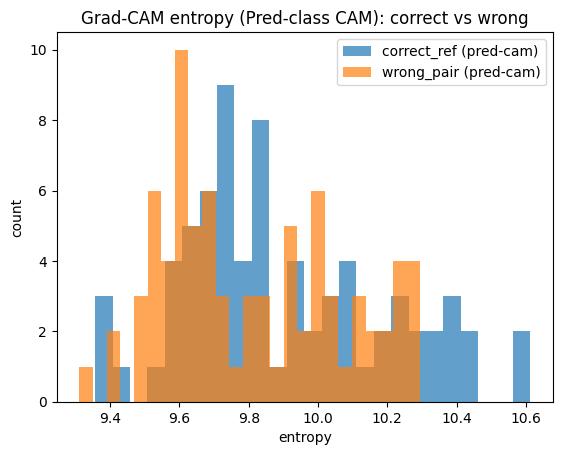

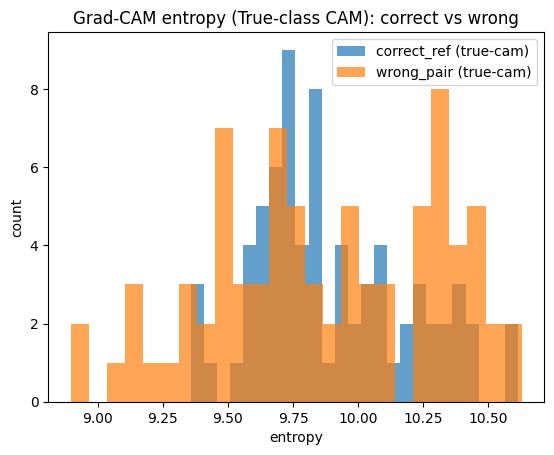

In [75]:
metrics_df = pd.read_csv("outputs/xai/gradcam/gradcam_metrics.csv")

plt.figure()
plt.hist(metrics_df.loc[metrics_df["selection_type"]=="correct_ref", "entropy_predcam"], bins=25, alpha=0.7, label="correct_ref (pred-cam)")
plt.hist(metrics_df.loc[metrics_df["selection_type"]=="wrong_pair", "entropy_predcam"], bins=25, alpha=0.7, label="wrong_pair (pred-cam)")
plt.title("Grad-CAM entropy (Pred-class CAM): correct vs wrong")
plt.xlabel("entropy")
plt.ylabel("count")
plt.legend()
plt.show()

plt.figure()
plt.hist(metrics_df.loc[metrics_df["selection_type"]=="correct_ref", "entropy_truecam"], bins=25, alpha=0.7, label="correct_ref (true-cam)")
plt.hist(metrics_df.loc[metrics_df["selection_type"]=="wrong_pair", "entropy_truecam"], bins=25, alpha=0.7, label="wrong_pair (true-cam)")
plt.title("Grad-CAM entropy (True-class CAM): correct vs wrong")
plt.xlabel("entropy")
plt.ylabel("count")
plt.legend()
plt.show()

## A stronger Grad-CAM metric = “peakiness”

In [76]:
sel_df = pd.read_csv("outputs/xai/gradcam/selected_cases.csv")

def topk_mass(hm, frac=0.05):
    """
    hm: 2D heatmap in [0,1]
    frac: fraction of pixels to consider as top-k
    returns: sum(top-k) / sum(all)
    """
    x = hm.astype(np.float64).clip(0, 1)
    x = x + 1e-12
    flat = x.ravel()
    k = max(1, int(len(flat) * frac))
    top = np.partition(flat, -k)[-k:]
    return float(top.sum() / flat.sum())

records = []

for idx, row in sel_df.iterrows():
    img_cam = load_image_for_model(row["filepath"])

    true_idx = label_to_id[row["true_name"]]
    pred_idx = label_to_id[row["pred_name"]]

    hm_pred = make_gradcam_heatmap(img_cam, pred_idx)
    hm_true = make_gradcam_heatmap(img_cam, true_idx)

    rec = {
        "filepath": row["filepath"],
        "true_name": row["true_name"],
        "pred_name": row["pred_name"],
        "is_correct": bool(row["is_correct"]),
        "selection_type": row["selection_type"],
        "p_true": float(row["p_true"]),
        "p_pred": float(row["p_pred"]),
        "top5_mass_predcam": topk_mass(hm_pred, 0.05),
        "top5_mass_truecam": topk_mass(hm_true, 0.05),
    }
    records.append(rec)

peak_df = pd.DataFrame(records)

out_path = Path("outputs/xai/gradcam/gradcam_peakiness.csv")
peak_df.to_csv(out_path, index=False)

print("✅ Saved:", out_path)
print(peak_df.groupby("selection_type")[["top5_mass_predcam", "top5_mass_truecam"]].mean())


✅ Saved: outputs/xai/gradcam/gradcam_peakiness.csv
                top5_mass_predcam  top5_mass_truecam
selection_type                                      
correct_ref              0.271460           0.271460
wrong_pair               0.291507           0.314266


## Plot peakiness distributions

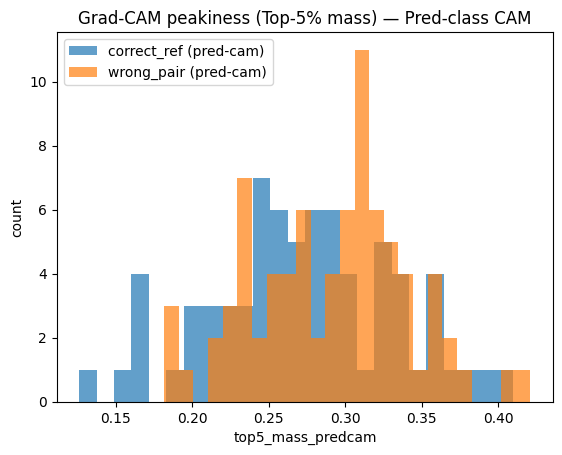

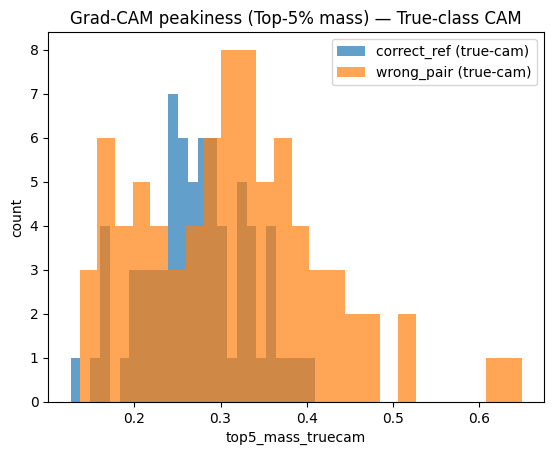

In [77]:
peak_df = pd.read_csv("outputs/xai/gradcam/gradcam_peakiness.csv")

plt.figure()
plt.hist(peak_df.loc[peak_df["selection_type"]=="correct_ref", "top5_mass_predcam"], bins=25, alpha=0.7, label="correct_ref (pred-cam)")
plt.hist(peak_df.loc[peak_df["selection_type"]=="wrong_pair", "top5_mass_predcam"], bins=25, alpha=0.7, label="wrong_pair (pred-cam)")
plt.title("Grad-CAM peakiness (Top-5% mass) — Pred-class CAM")
plt.xlabel("top5_mass_predcam")
plt.ylabel("count")
plt.legend()
plt.show()

plt.figure()
plt.hist(peak_df.loc[peak_df["selection_type"]=="correct_ref", "top5_mass_truecam"], bins=25, alpha=0.7, label="correct_ref (true-cam)")
plt.hist(peak_df.loc[peak_df["selection_type"]=="wrong_pair", "top5_mass_truecam"], bins=25, alpha=0.7, label="wrong_pair (true-cam)")
plt.title("Grad-CAM peakiness (Top-5% mass) — True-class CAM")
plt.xlabel("top5_mass_truecam")
plt.ylabel("count")
plt.legend()
plt.show()


## Identify the most extreme wrong cases `(highest peakiness)` and save a shortlist

In [78]:
peak_df = pd.read_csv("outputs/xai/gradcam/gradcam_peakiness.csv")

# Top 12 most extreme wrong cases by TRUE-class peakiness
extreme_wrong = (
    peak_df[peak_df["selection_type"]=="wrong_pair"]
    .sort_values("top5_mass_truecam", ascending=False)
    .head(12)
)

out_path = Path("outputs/xai/gradcam/extreme_wrong_cases.csv")
extreme_wrong.to_csv(out_path, index=False)

print("✅ Saved:", out_path)
extreme_wrong[["true_name","pred_name","p_true","p_pred","top5_mass_truecam","top5_mass_predcam","filepath"]]

✅ Saved: outputs/xai/gradcam/extreme_wrong_cases.csv


,true_name,pred_name,p_true,p_pred,top5_mass_truecam,top5_mass_predcam,filepath
74,Binadhan24,Binadhan10,0.106945,0.468667,0.648997,0.286801,data/raw/Binadhan24/binadhan24 (382).jpg
73,Binadhan24,Binadhan10,0.060522,0.491253,0.620381,0.234602,data/raw/Binadhan24/binadhan24 (262).jpg
68,Binadhan17,Binadhan12,0.128561,0.433581,0.516202,0.315351,data/raw/Binadhan17/binadhan17 (387).jpg
24,BD87,BD57,0.052394,0.859837,0.511411,0.230358,data/raw/BD87/bd87 (362).jpg
50,BD57,BD87,0.293277,0.520543,0.475929,0.357343,data/raw/BD57/bd57 (211).jpg
67,Binadhan17,Binadhan12,0.188200,0.439458,0.467826,0.271122,data/raw/Binadhan17/binadhan17 (96).jpg
64,Binadhan17,Binadhan12,0.192749,0.772399,0.462666,0.241722,data/raw/Binadhan17/binadhan17 (348).jpg
26,BD87,BD57,0.087837,0.554456,0.451501,0.282959,data/raw/BD87/bd87 (57).jpg
69,Binadhan17,Binadhan12,0.128511,0.387593,0.443222,0.222214,data/raw/Binadhan17/binadhan17 (265).jpg
72,Binadhan24,Binadhan10,0.165853,0.494328,0.435005,0.228488,data/raw/Binadhan24/binadhan24 (13).jpg


## Generate a 4-panel figure for the top 6 extreme cases (journal-ready)

In [79]:
extreme = pd.read_csv("outputs/xai/gradcam/extreme_wrong_cases.csv").head(6)

OUT_DIR = Path("outputs/xai/gradcam/extreme_panels")
OUT_DIR.mkdir(parents=True, exist_ok=True)

for i, row in extreme.iterrows():
    img_cam = load_image_for_model(row["filepath"])
    img_disp = tf.image.decode_jpeg(tf.io.read_file(row["filepath"]), channels=3).numpy()

    true_idx = label_to_id[row["true_name"]]
    pred_idx = label_to_id[row["pred_name"]]

    hm_pred = make_gradcam_heatmap(img_cam, pred_idx)
    hm_true = make_gradcam_heatmap(img_cam, true_idx)

    ov_pred = overlay_heatmap_on_rgb(img_disp, hm_pred)
    ov_true = overlay_heatmap_on_rgb(img_disp, hm_true)

    plt.figure(figsize=(12, 6))

    plt.subplot(2, 2, 1)
    plt.imshow(img_disp)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(2, 2, 2)
    plt.imshow(ov_pred)
    plt.title(f"Grad-CAM (Pred: {row['pred_name']})")
    plt.axis("off")

    plt.subplot(2, 2, 3)
    plt.imshow(ov_true)
    plt.title(f"Grad-CAM (True: {row['true_name']})")
    plt.axis("off")

    plt.subplot(2, 2, 4)
    plt.axis("off")
    txt = (
        f"True: {row['true_name']}  |  Pred: {row['pred_name']}\n"
        f"p_true = {row['p_true']:.3f}   p_pred = {row['p_pred']:.3f}\n"
        f"top5_mass_truecam = {row['top5_mass_truecam']:.3f}\n"
        f"top5_mass_predcam = {row['top5_mass_predcam']:.3f}\n"
        f"file: {Path(row['filepath']).name}"
    )
    plt.text(0.02, 0.85, txt, fontsize=11, family="monospace")

    plt.tight_layout()

    outpath = OUT_DIR / f"extreme_{i:02d}__{row['true_name']}__pred_{row['pred_name']}.png"
    plt.savefig(outpath, dpi=150)
    plt.close()

print("✅ Saved extreme panels to:", OUT_DIR)


✅ Saved extreme panels to: outputs/xai/gradcam/extreme_panels
